In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re
from wordcloud import WordCloud
import time
import pandas as pd
import nltk
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
import numpy as np
import pickle

In [2]:
# Hvis du ønsker at samle alle chunks til én DataFrame (vær opmærksom på hukommelsen):
dfs = []
with open('articles_preprocessed_1mio.pkl', 'rb') as f:
    while True:
        try:
            chunk = pickle.load(f)
            dfs.append(chunk)
        except EOFError:
            break

df_wo_stems = pd.concat(dfs, ignore_index=True)
print("Samlet DataFrame shape:", df_wo_stems.shape)

print("Antal artikler:", len(df_wo_stems))

Samlet DataFrame shape: (581918, 2)
Antal artikler: 581918


In [3]:
# Hvis 'content' er gemt som en streng, der repræsenterer en liste, konverter den:
def parse_content(text):
    try:
        return eval(text) if isinstance(text, str) and text.startswith('[') else text
    except Exception:
        return text
    
# Funktion til at filtrere uønskede tokens
def filter_tokens(tokens):
    # Liste med specifikke tokens, som vi ønsker at fjerne
    unwanted_tokens = {'num'}
    # Returner kun tokens, der er udelukkende alfabetiske (dvs. ingen symboler eller tegn) 
    # og som ikke er i unwanted_tokens
    return [token for token in tokens if token.isalpha() and token not in unwanted_tokens]

# Funktion til at join tokens fra en serie med token-lister
def join_tokens(tokens_series):
    # For hver token-liste filtrerer vi tokens og joiner dem til én streng
    return ' '.join([' '.join(filter_tokens(tokens)) for tokens in tokens_series if isinstance(tokens, list)])


In [5]:
df_wo_stems['content'] = df_wo_stems['content'].apply(parse_content)

In [6]:
label_counts = df_wo_stems['LABEL'].value_counts().sort_index()
print("Label-fordeling:\n", label_counts)

Label-fordeling:
 LABEL
0.0    141425
1.0    440493
Name: count, dtype: int64


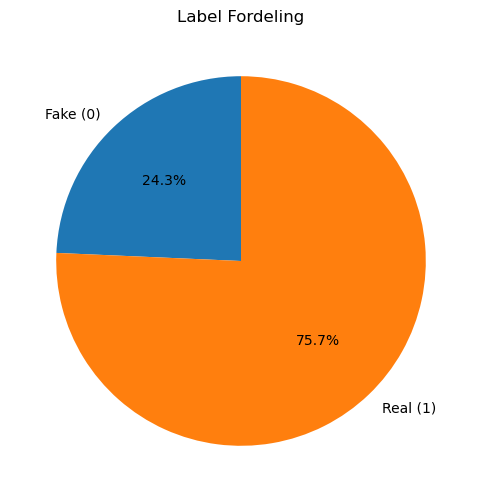

In [7]:
# Eksempel: Visualisering af label-fordelingen
plt.figure(figsize=(6,6))
label_counts.plot.pie(autopct='%1.1f%%', startangle=90, labels=['Fake (0)', 'Real (1)'])
plt.title('Label Fordeling')
plt.ylabel('')
plt.show()

In [11]:
# Lav ordfrekvensanalyser for Fake News (LABEL == 0) og Real News (LABEL == 1)
# Fake news
fake_text = join_tokens(df_wo_stems[df_wo_stems['LABEL'] == 0]['content'])
word_counts_fake = Counter(fake_text.split())
most_common_fake = word_counts_fake.most_common(20)
print("\nMest hyppige ord i Fake News:")
print(most_common_fake)

# Real news
real_text = join_tokens(df_wo_stems[df_wo_stems['LABEL'] == 1]['content'])
word_counts_real = Counter(real_text.split())
most_common_real = word_counts_real.most_common(20)
print("\nMest hyppige ord i Real News:")
print(most_common_real)


Mest hyppige ord i Fake News:
[('use', 163469), ('one', 141526), ('system', 136274), ('would', 134260), ('like', 133206), ('peopl', 125791), ('state', 124109), ('us', 122158), ('time', 111482), ('said', 111058), ('year', 108091), ('also', 107905), ('tor', 100553), ('go', 90935), ('make', 90006), ('govern', 88658), ('new', 82481), ('report', 81285), ('tail', 81081), ('see', 76912)]

Mest hyppige ord i Real News:
[('said', 915813), ('new', 639186), ('one', 596551), ('year', 573098), ('time', 571735), ('mr', 511891), ('would', 486511), ('state', 475334), ('peopl', 444160), ('like', 435568), ('iran', 323939), ('also', 312689), ('say', 310898), ('stori', 310155), ('continu', 305302), ('make', 298678), ('even', 296402), ('trump', 295734), ('get', 293057), ('work', 292486)]


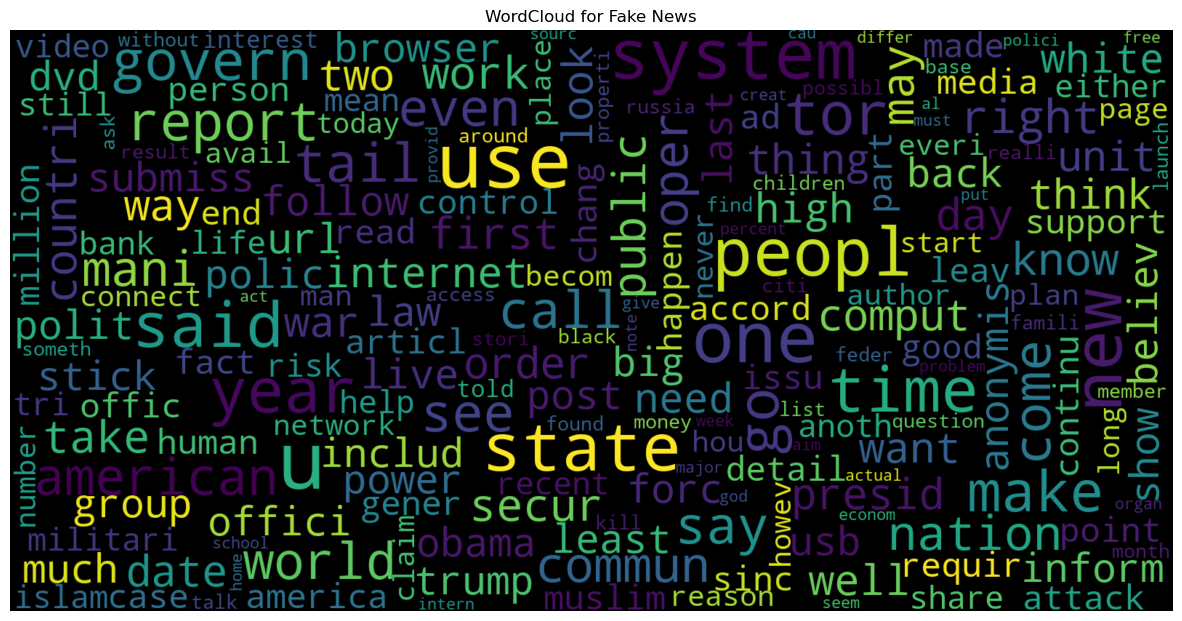

In [12]:
# 4. WordCloud for Fake News
wordCloudFake = WordCloud(width=1600,
                          height=800,
                          random_state=21,
                          max_font_size=110,
                          collocations=False).generate(fake_text)

plt.figure(figsize=(15, 10))
plt.imshow(wordCloudFake, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud for Fake News")
plt.show()

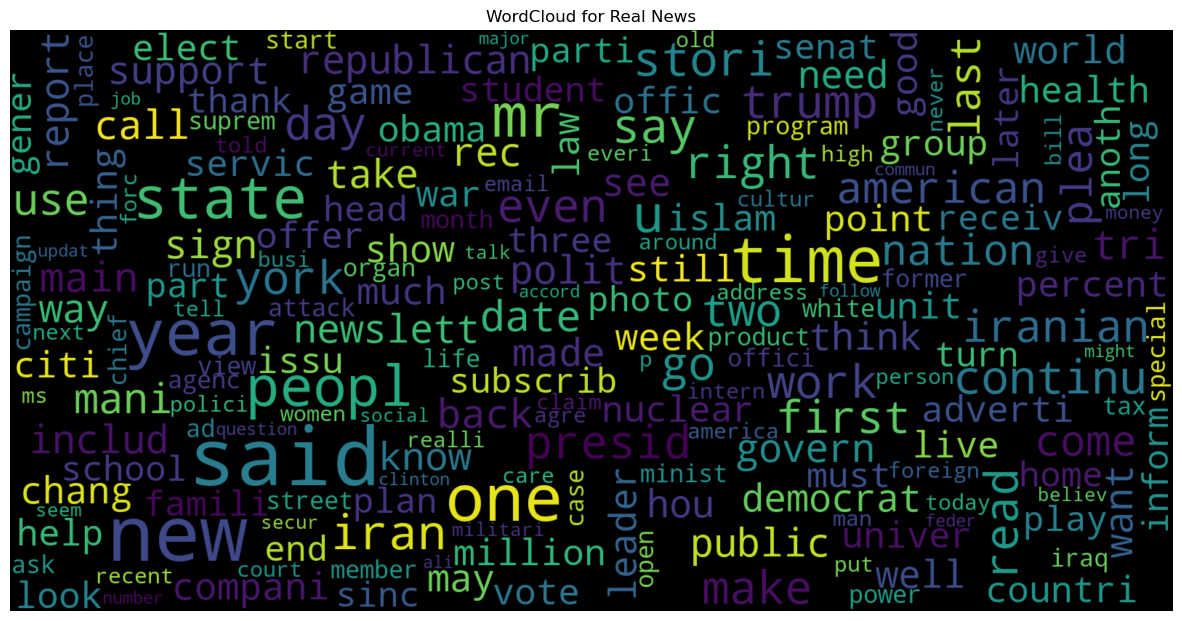

In [ ]:
# Opret en WordCloud for real news
wordCloudReal = WordCloud(width=1600,
                          height=800,
                          random_state=21,
                          max_font_size=110,
                          collocations=False).generate(real_text)

plt.figure(figsize=(15, 10))
plt.imshow(wordCloudReal, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud for Real News")
plt.show()


In [12]:
def filter_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words and word not in ['num', '-']]

# Opret en ny kolonne 'filtered_content' i dit DataFrame ved at anvende funktionen på kolonnen 'content'
# Her antages det, at 'content' allerede indeholder lister af tokens
df['filtered_content'] = df['content'].apply(filter_stopwords)

# Opret en samlet tekststreng for fake artikler (LABEL == 0)
fake_text_filtered = ' '.join([' '.join(tokens) for tokens in df[df['LABEL'] == 0]['filtered_content'] if isinstance(tokens, list)])

# Opret en samlet tekststreng for real artikler (LABEL == 1)
real_text_filtered = ' '.join([' '.join(tokens) for tokens in df[df['LABEL'] == 1]['filtered_content'] if isinstance(tokens, list)])

# Eksempel: Udskriv de første 100 tegn af hver for at tjekke resultatet
print("Fake News tekst (filtreret):", fake_text_filtered[:100])
print("Real News tekst (filtreret):", real_text_filtered[:100])

Fake News tekst (filtreret): – compiled studies vaccine dangers activist post date shortage research regarding negative effects w
Real News tekst (filtreret): plus one article google plus thanks ali alfoneh assistance compiling politics nuclear issue supreme 


In [14]:
def is_meaningful(token):
    # Returner True, hvis token indeholder mindst ét alfanumerisk tegn
    return any(char.isalnum() for char in token)

# Eksempel for fake artikler: Saml alle tokens fra 'filtered_content' og filtrer de ubrugelige tokens
fake_tokens_filtered = [
    word 
    for tokens in df[df['LABEL'] == 0]['filtered_content'] 
    if isinstance(tokens, list)
    for word in tokens 
    if is_meaningful(word)
]

# Udregn de 20 mest hyppige meningsfulde ord i fake news
from collections import Counter
most_common_fake = Counter(fake_tokens_filtered).most_common(20)
print("Top 20 Fake News ord (filtreret):", most_common_fake)

# Gør tilsvarende for real artikler:
real_tokens_filtered = [
    word 
    for tokens in df[df['LABEL'] == 1]['filtered_content'] 
    if isinstance(tokens, list)
    for word in tokens 
    if is_meaningful(word)
]

most_common_real = Counter(real_tokens_filtered).most_common(20)
print("Top 20 Real News ord (filtreret):", most_common_real)

Top 20 Fake News ord (filtreret): [('one', 134924), ('would', 134260), ('system', 129131), ('people', 123534), ('us', 122157), ('like', 113027), ('said', 111055), ('also', 107904), ('tor', 100539), ('use', 84059), ('time', 83734), ('new', 82461), ('tails', 80435), ('government', 77387), ('world', 70944), ('even', 70128), ('see', 69658), ('could', 64849), ('many', 64635), ('state', 63404)]
Top 20 Real News ord (filtreret): [('said', 915810), ('new', 639083), ('one', 574346), ('mr', 491562), ('would', 486509), ('people', 441063), ('like', 362649), ('year', 328604), ('iran', 323931), ('time', 318959), ('also', 312687), ('trump', 292983), ('york', 286936), ('first', 275513), ('story', 274548), ('two', 273661), ('even', 273320), ('iranian', 265542), ('president', 259145), ('state', 256676)]


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Først skal du samle tokens til en streng per artikel
df['filtered_text'] = df['filtered_content'].apply(lambda tokens: " ".join(tokens) if isinstance(tokens, list) else "")

# Anvend TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=10000)
tfidf_matrix = vectorizer.fit_transform(df['filtered_text'])

# Du kan nu inspicere de højeste TF-IDF-værdier pr. artikel eller globalt
feature_names = vectorizer.get_feature_names_out()

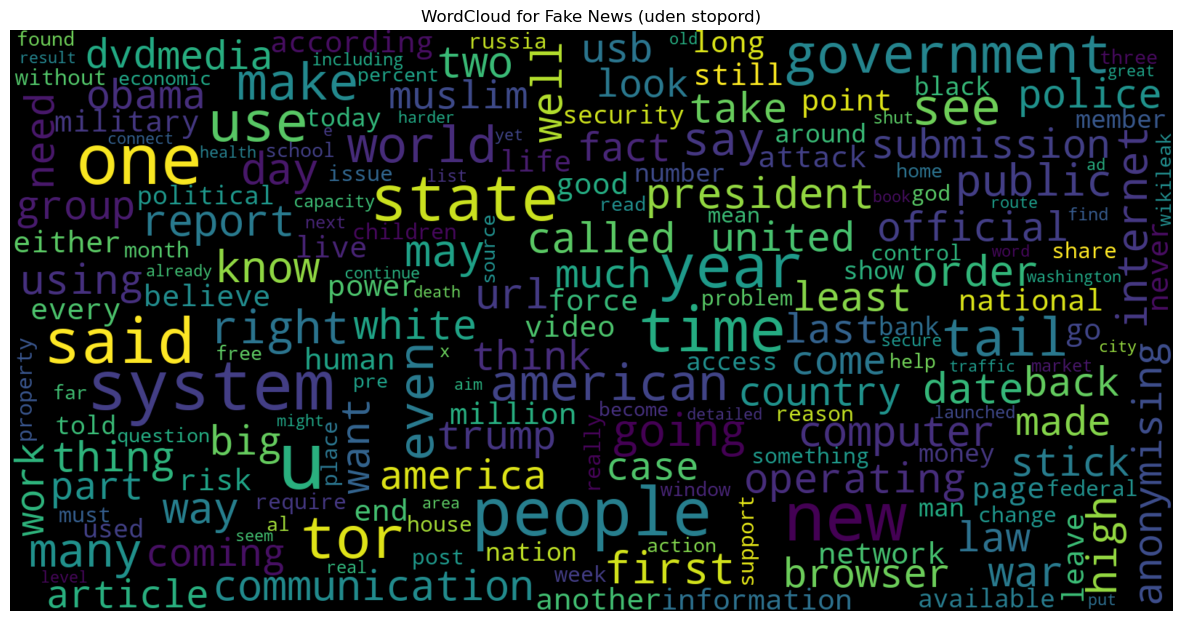

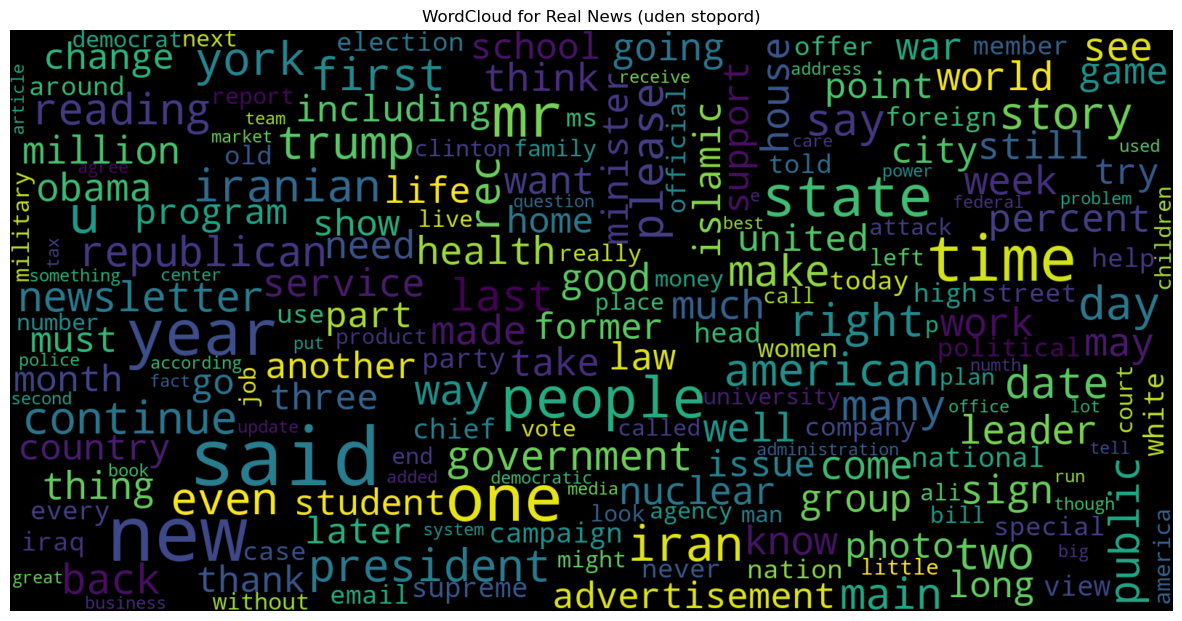

In [16]:

def generate_wordcloud(tokens_list, title):
    text = ' '.join(tokens_list)
    wordcloud = WordCloud(width=1600, height=800, random_state=21, max_font_size=110, collocations=False).generate(text)
    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# For fake artikler:
fake_tokens_filtered = [word for tokens in df[df['LABEL'] == 0]['filtered_content'] if isinstance(tokens, list) for word in tokens]
generate_wordcloud(fake_tokens_filtered, "WordCloud for Fake News (uden stopord)")

# For real artikler:
real_tokens_filtered = [word for tokens in df[df['LABEL'] == 1]['filtered_content'] if isinstance(tokens, list) for word in tokens]
generate_wordcloud(real_tokens_filtered, "WordCloud for Real News (uden stopord)")

In [19]:


# Del datasættet op i fake (LABEL == 0) og real (LABEL == 1)
mask_fake = (df['LABEL'] == 0)
mask_real = (df['LABEL'] == 1)

tfidf_fake = tfidf_matrix[mask_fake]
tfidf_real = tfidf_matrix[mask_real]

# Beregn den gennemsnitlige TF-IDF-score for hvert ord i hver gruppe
mean_tfidf_fake = np.array(tfidf_fake.mean(axis=0)).flatten()
mean_tfidf_real = np.array(tfidf_real.mean(axis=0)).flatten()

# Få de top 20 ord med den højeste gennemsnitlige score for hver gruppe
top_n = 20
top_indices_fake = np.argsort(mean_tfidf_fake)[::-1][:top_n]
top_indices_real = np.argsort(mean_tfidf_real)[::-1][:top_n]

top_words_fake = [(feature_names[i], mean_tfidf_fake[i]) for i in top_indices_fake]
top_words_real = [(feature_names[i], mean_tfidf_real[i]) for i in top_indices_real]

print("Top 20 TF-IDF ord for Fake News:")
for word, score in top_words_fake:
    print(f"{word}: {score:.4f}")

print("\nTop 20 TF-IDF ord for Real News:")
for word, score in top_words_real:
    print(f"{word}: {score:.4f}")

Top 20 TF-IDF ord for Fake News:
tor: 0.0634
tails: 0.0506
system: 0.0489
ad: 0.0326
anonymising: 0.0254
usb: 0.0254
browser: 0.0251
dvd: 0.0251
submission: 0.0250
property: 0.0249
stick: 0.0240
like: 0.0237
communications: 0.0235
computer: 0.0234
operating: 0.0233
internet: 0.0233
use: 0.0227
using: 0.0226
com: 0.0198
us: 0.0194

Top 20 TF-IDF ord for Real News:
iran: 0.0342
said: 0.0339
iranian: 0.0307
mr: 0.0256
new: 0.0233
one: 0.0191
trump: 0.0181
would: 0.0176
people: 0.0170
recs: 0.0170
date: 0.0164
nuclear: 0.0161
islamic: 0.0155
york: 0.0150
year: 0.0144
president: 0.0135
news: 0.0135
like: 0.0131
story: 0.0128
time: 0.0128


In [20]:
print("\nTop 20 TF-IDF ord for Real News:")
for word, score in top_words_real:
    print(f"{word}: {score:.4f}")


Top 20 TF-IDF ord for Real News:
iran: 0.0342
said: 0.0339
iranian: 0.0307
mr: 0.0256
new: 0.0233
one: 0.0191
trump: 0.0181
would: 0.0176
people: 0.0170
recs: 0.0170
date: 0.0164
nuclear: 0.0161
islamic: 0.0155
york: 0.0150
year: 0.0144
president: 0.0135
news: 0.0135
like: 0.0131
story: 0.0128
time: 0.0128


In [21]:
def token_percentage(tokens_series, token):
    """
    Beregner procentdelen af et specifikt token i et givet pandas Series,
    hvor hver række er en liste af tokens.
    """
    token = token.lower()  # Sørg for, at token er i lower-case
    total_tokens = 0
    token_occurrences = 0
    for tokens in tokens_series:
        if isinstance(tokens, list):
            total_tokens += len(tokens)
            token_occurrences += tokens.count(token)
    return (token_occurrences / total_tokens * 100) if total_tokens > 0 else 0

# Filtrer fake og real artikler ud fra LABEL
fake_tokens = df[df['LABEL'] == 0]['filtered_content']
real_tokens = df[df['LABEL'] == 1]['filtered_content']

# Beregn procentdelen af ordet "muslim" i hver gruppe
fake_muslim_percentage = token_percentage(fake_tokens, 'muslim')
real_muslim_percentage = token_percentage(real_tokens, 'muslim')

print(f"Procentdel af 'muslim' i Fake News: {fake_muslim_percentage:.2f}%")
print(f"Procentdel af 'muslim' i Real News: {real_muslim_percentage:.2f}%")

Procentdel af 'muslim' i Fake News: 0.07%
Procentdel af 'muslim' i Real News: 0.01%


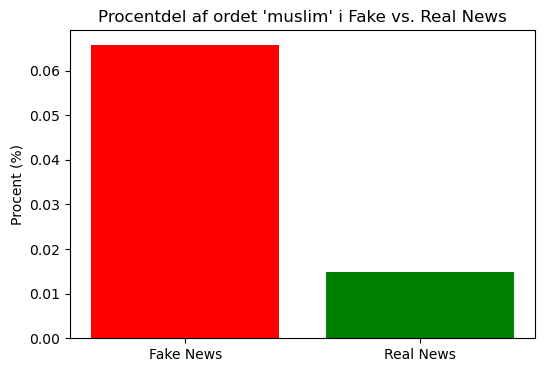

In [22]:
labels = ['Fake News', 'Real News']
percentages = [fake_muslim_percentage, real_muslim_percentage]

plt.figure(figsize=(6,4))
plt.bar(labels, percentages, color=['red', 'green'])
plt.ylabel("Procent (%)")
plt.title("Procentdel af ordet 'muslim' i Fake vs. Real News")
plt.show()

In [23]:
def articles_with_token_percentage(tokens_series, token):
    """
    Beregner, hvor mange artikler i en given pandas Series (hvor hver række er en liste af tokens)
    der indeholder et specifikt token mindst én gang.
    Returnerer antallet af artikler med token, total antal artikler, og procentdelen.
    """
    token = token.lower()
    count = 0
    total = 0
    for tokens in tokens_series:
        if isinstance(tokens, list):
            total += 1
            if token in tokens:
                count += 1
    percentage = (count / total * 100) if total > 0 else 0
    return count, total, percentage

# Filtrer artikler for fake (LABEL == 0) og real (LABEL == 1)
fake_articles_tokens = df[df['LABEL'] == 0]['filtered_content']
real_articles_tokens = df[df['LABEL'] == 1]['filtered_content']

fake_count, fake_total, fake_percentage = articles_with_token_percentage(fake_articles_tokens, 'muslim')
real_count, real_total, real_percentage = articles_with_token_percentage(real_articles_tokens, 'muslim')

print(f"Fake News: {fake_percentage:.2f}% af artiklerne indeholder 'muslim' ({fake_count} ud af {fake_total}).")
print(f"Real News: {real_percentage:.2f}% af artiklerne indeholder 'muslim' ({real_count} ud af {real_total}).")


Fake News: 4.12% af artiklerne indeholder 'muslim' (5821 ud af 141425).
Real News: 2.08% af artiklerne indeholder 'muslim' (9169 ud af 440493).


In [24]:
def articles_with_phrase_percentage(tokens_series, phrase):
    """
    Beregner, hvor mange artikler i en pandas Series (hvor hver artikel er en liste af tokens)
    der indeholder den specifikke frase mindst én gang.
    """
    phrase = phrase.lower()
    count = 0
    total = 0
    for tokens in tokens_series:
        if isinstance(tokens, list):
            total += 1
            article_text = " ".join(tokens)
            if phrase in article_text:
                count += 1
    percentage = (count / total * 100) if total > 0 else 0
    return count, total, percentage

donald_trump_fake_count, donald_trump_fake_total, donald_trump_fake_pct = articles_with_phrase_percentage(fake_articles_tokens, "donald trump")
donald_trump_real_count, donald_trump_real_total, donald_trump_real_pct = articles_with_phrase_percentage(real_articles_tokens, "donald trump")

print(f"Fake News: {donald_trump_fake_pct:.2f}% af artiklerne indeholder 'donald trump' ({donald_trump_fake_count} ud af {donald_trump_fake_total}).")
print(f"Real News: {donald_trump_real_pct:.2f}% af artiklerne indeholder 'donald trump' ({donald_trump_real_count} ud af {donald_trump_real_total}).")


Fake News: 3.15% af artiklerne indeholder 'donald trump' (4450 ud af 141425).
Real News: 6.76% af artiklerne indeholder 'donald trump' (29789 ud af 440493).
